# 캐글 신용카드 사기 검출 데이터 실습

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv("./creditcard.csv")
print('dataset shape:', card_df.shape)
card_df.head(3)

dataset shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


# 언더 샘플링, 오버 샘플링

# 전처리 
- Time 피처 제거


## 전처리 함수 get_preprocessed_df()

In [117]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)

    
    return df_copy

In [118]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함
def get_train_test_dataset(df=None):
    #인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    #DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    #학습/테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [119]:
# 분포 확인
print(f'학습데이터의 사기거래 비율은:\n{y_train.value_counts()/y_train.shape[0]*100}')
print(f'테스트데이터의 사기거래 비율은:\n{y_test.value_counts()/y_test.shape[0]*100}')

학습데이터의 사기거래 비율은:
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트데이터의 사기거래 비율은:
0    99.826785
1     0.173215
Name: Class, dtype: float64


## 출력 함수

In [120]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_probs=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred) 
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)

    print('오차 행렬:\n', confusion)
    print(f'정확도: {accuracy}, 정밀도: {precision}, 재현율: {recall},\
    F1: {f1}, ROC-AUC:{roc_auc}')

# LogisticRegression 로지스틱 회귀 모델 생성 

In [121]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

print('### LogisticRegression 예측 성능 ###')
get_clf_eval(y_test, lr_pred, lr_pred_proba)

### LogisticRegression 예측 성능 ###
오차 행렬:
 [[85280    15]
 [   56    92]]
정확도: 0.99916903666772, 정밀도: 0.8598130841121495, 재현율: 0.6216216216216216,    F1: 0.7215686274509804, ROC-AUC:0.81072288068595


## 학습/예측/평가 함수

In [122]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)


# LightGBM 모델

In [123]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
print('### LGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### LGBM 예측 성능 ###
오차 행렬:
 [[85290     5]
 [   36   112]]
정확도: 0.9995201479348805, 정밀도: 0.9572649572649573, 재현율: 0.7567567567567568,    F1: 0.8452830188679246, ROC-AUC:0.8783490683367581


# 데이터 분포도 변환 후 모델 학습/예측/평가

## 1. Amount 피처

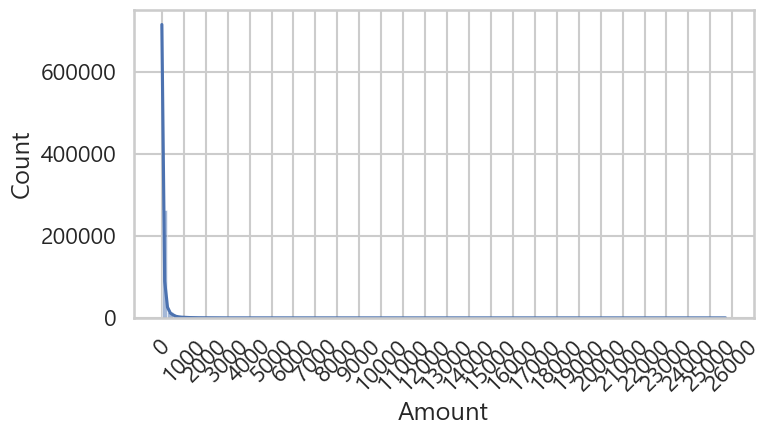

In [124]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=45)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

### 1.1 Amount - StandardScaler 스케일링 처리

In [125]:
from sklearn.preprocessing import StandardScaler

# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df=None):
    df_copy = df.copy()

    # Amount Scaling
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    # 변환된 Amount를 Amount_scaled로 피처명 변경후 DataFrame 맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    return df_copy

In [126]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [127]:
print('### StandardScaler+LogisticRegression 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### StandardScaler+LGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### StandardScaler+LogisticRegression 예측 성능 ###
오차 행렬:
 [[85281    14]
 [   58    90]]
정확도: 0.9991573329588147, 정밀도: 0.8653846153846154, 재현율: 0.6081081081081081,    F1: 0.7142857142857144, ROC-AUC:0.8039719859375173
### StandardScaler+LGBM 예측 성능 ###
오차 행렬:
 [[85290     5]
 [   37   111]]
정확도: 0.9995084442259752, 정밀도: 0.9568965517241379, 재현율: 0.75,    F1: 0.8409090909090909, ROC-AUC:0.8749706899583798


### 1.2 Amount - Log 처리

In [128]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p()를 이용해 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy


In [129]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [130]:
print('### Log처리+LogisticRegression 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### Log처리+LGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### Log처리+LogisticRegression 예측 성능 ###
오차 행렬:
 [[85283    12]
 [   59    89]]
정확도: 0.99916903666772, 정밀도: 0.8811881188118812, 재현율: 0.6013513513513513,    F1: 0.714859437751004, ROC-AUC:0.8006053315757872
### Log처리+LGBM 예측 성능 ###
오차 행렬:
 [[85290     5]
 [   35   113]]
정확도: 0.9995318516437859, 정밀도: 0.9576271186440678, 재현율: 0.7635135135135135,    F1: 0.849624060150376, ROC-AUC:0.8817274467151365


# 이상치 데이터 제거 후 모델 학습/예측/평가

## 1. 피처의 상관관계 - 중요도 파악

<AxesSubplot:>

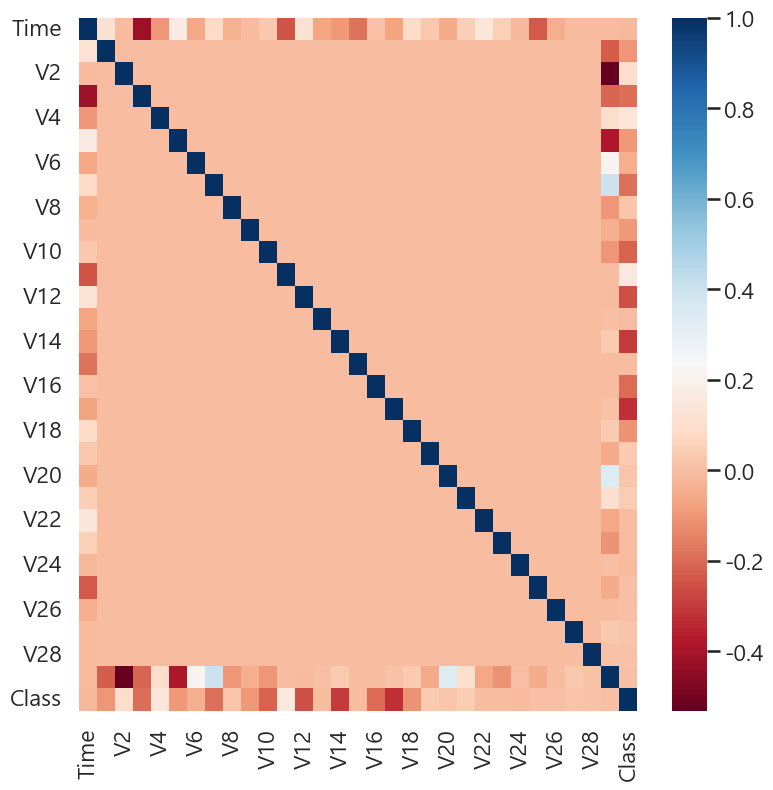

In [131]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')


결정 레이블인 Class 피처와 음의 상관관계가 가장 높은 피처는 V14, V17입니다. 이 중 V14에 대해서만 이상치를 찾아서 제거. 

## 2. 이상치 검출 함수

### 2.1 V14 컬럼 이상치 제거

In [132]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud 에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    #IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환.
    outlier_index = fraud[(fraud<lowest_val)|(fraud>highest_val)].index
    return outlier_index


In [133]:
# V14 컬럼에서 이상치 찾기

outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index) 

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [134]:
# 이상치가 발견된 [8296, 8615, 9035, 9252] 인덱스 - 이상치 추출, 삭제 하는 로직을 get_processed_df() 함수에 추가

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p()를 이용해 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    # # V14와 V17 컬럼의 이상치 제거
    # for column in ['V14', 'V17']:
    #     outlier_index = get_outlier(df=df_copy, column=column, weight=1.5)
    #     df_copy.drop(outlier_index, axis=0, inplace=True)
    # return df_copy

    return df_copy

In [135]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### V14 이상치처리+LogisticRegression 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### V14 이상치처리+LGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### V14 이상치처리+LogisticRegression 예측 성능 ###
오차 행렬:
 [[85281    14]
 [   48    98]]
정확도: 0.9992743530623471, 정밀도: 0.875, 재현율: 0.6712328767123288,    F1: 0.7596899224806201, ROC-AUC:0.8355343702396276
### V14 이상치처리+LGBM 예측 성능 ###
오차 행렬:
 [[85290     5]
 [   25   121]]
정확도: 0.9996488805140389, 정밀도: 0.9603174603174603, 재현율: 0.8287671232876712,    F1: 0.8897058823529411, ROC-AUC:0.9143542516022153


### 2.2 V17 컬럼 이상치 제거

In [136]:
# V14 컬럼에서 이상치 찾기

outlier_index_V17 = get_outlier(df=card_df, column='V17', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index_V17) 

이상치 데이터 인덱스: Int64Index([], dtype='int64')


In [137]:
card_df.drop(outlier_index_V17, axis=0, inplace=True)

In [138]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### V17 이상치처리+LogisticRegression 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### V17 이상치처리+LGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### V17 이상치처리+LogisticRegression 예측 성능 ###
오차 행렬:
 [[85281    14]
 [   48    98]]
정확도: 0.9992743530623471, 정밀도: 0.875, 재현율: 0.6712328767123288,    F1: 0.7596899224806201, ROC-AUC:0.8355343702396276
### V17 이상치처리+LGBM 예측 성능 ###
오차 행렬:
 [[85290     5]
 [   25   121]]
정확도: 0.9996488805140389, 정밀도: 0.9603174603174603, 재현율: 0.8287671232876712,    F1: 0.8897058823529411, ROC-AUC:0.9143542516022153


# SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [139]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포:\n',pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포:
 0    199020
1    199020
Name: Class, dtype: int64


## 로지스틱 회귀 모델 (SMOTE 오버 샘플링 적용 후)

In [140]:
lr_clf = LogisticRegression(max_iter=1000)

# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
print('### SMOTE오버샘플링+LogisticRegression 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

### SMOTE오버샘플링+LogisticRegression 예측 성능 ###
오차 행렬:
 [[82937  2358]
 [   11   135]]
정확도: 0.9722732645919406, 정밀도: 0.05415162454873646, 재현율: 0.9246575342465754,    F1: 0.10231148162182646, ROC-AUC:0.9485061514951734


In [141]:
# 시각화 precision_recall_curve_plot

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

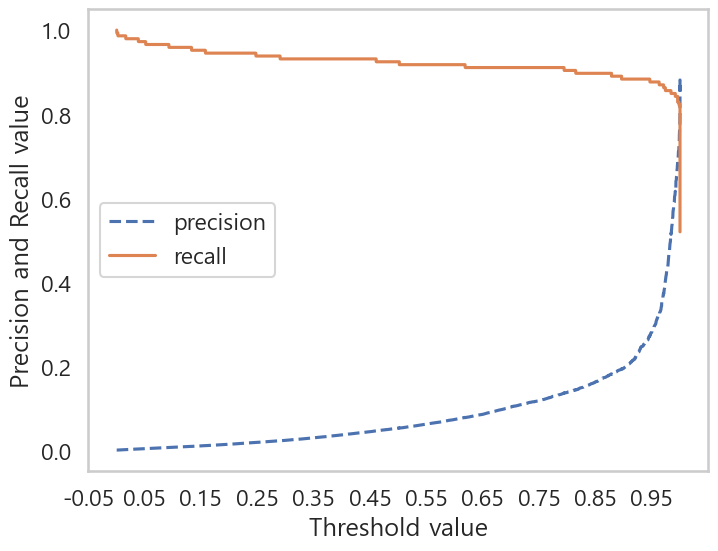

In [142]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

## LightGBM 모델 (SMOTE 오버 샘플링 적용 후)

In [143]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
print('### SMOTE오버샘플링+LGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

### SMOTE오버샘플링+LGBM 예측 성능 ###
오차 행렬:
 [[85283    12]
 [   22   124]]
정확도: 0.9996020645825775, 정밀도: 0.9117647058823529, 재현율: 0.8493150684931506,    F1: 0.8794326241134752, ROC-AUC:0.9245871901466867


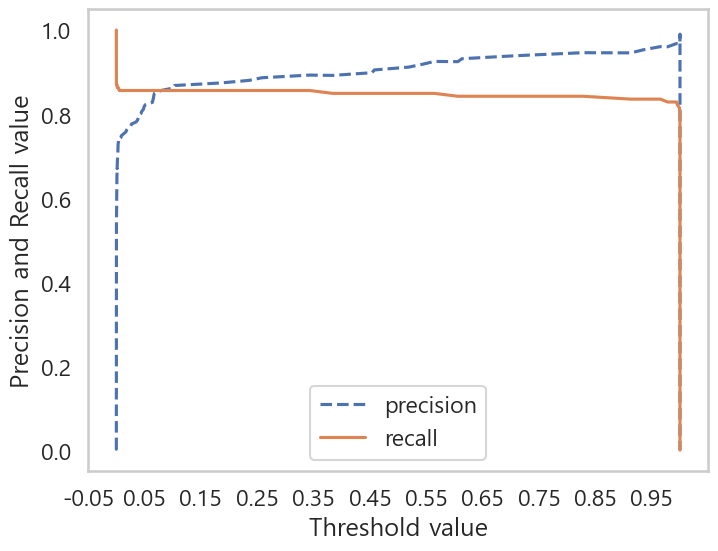

In [144]:
precision_recall_curve_plot( y_test, lgbm_clf.predict_proba(X_test)[:, 1] )

# 성능 비교

```
### LogisticRegression 예측 성능 ###
오차 행렬:
 [[85280    15]
 [   56    92]]
정확도: 0.99916903666772, 정밀도: 0.8598130841121495, 재현율: 0.6216216216216216,    F1: 0.7215686274509804, ROC-AUC:0.81072288068595

### LGBM 예측 성능 ###
오차 행렬:
 [[85290     5]
 [   36   112]]
정확도: 0.9995201479348805, 정밀도: 0.9572649572649573, 재현율: 0.7567567567567568,    F1: 0.8452830188679246, ROC-AUC:0.8783490683367581



### StandardScaler+LogisticRegression 예측 성능 ###
오차 행렬:
 [[85281    14]
 [   58    90]]
정확도: 0.9991573329588147, 정밀도: 0.8653846153846154, 재현율: 0.6081081081081081,    F1: 0.7142857142857144, ROC-AUC:0.8039719859375173
### StandardScaler+LGBM 예측 성능 ###
오차 행렬:
 [[85290     5]
 [   37   111]]
정확도: 0.9995084442259752, 정밀도: 0.9568965517241379, 재현율: 0.75,    F1: 0.8409090909090909, ROC-AUC:0.8749706899583798



### Log처리+LogisticRegression 예측 성능 ###
오차 행렬:
 [[85283    12]
 [   59    89]]
정확도: 0.99916903666772, 정밀도: 0.8811881188118812, 재현율: 0.6013513513513513,    F1: 0.714859437751004, ROC-AUC:0.8006053315757872

### Log처리+LGBM 예측 성능 ###
오차 행렬:
 [[85290     5]
 [   35   113]]
정확도: 0.9995318516437859, 정밀도: 0.9576271186440678, 재현율: 0.7635135135135135,    F1: 0.849624060150376, ROC-AUC:0.8817274467151365



### V14 이상치처리+LogisticRegression 예측 성능 ###
오차 행렬:
 [[85281    14]
 [   48    98]]
정확도: 0.9992743530623471, 정밀도: 0.875, 재현율: 0.6712328767123288,    F1: 0.7596899224806201, ROC-AUC:0.8355343702396276
### V14 이상치처리+LGBM 예측 성능 ###
오차 행렬:
 [[85290     5]
 [   25   121]]
정확도: 0.9996488805140389, 정밀도: 0.9603174603174603, 재현율: 0.8287671232876712,    F1: 0.8897058823529411, ROC-AUC:0.9143542516022153


### V17 이상치처리+LogisticRegression 예측 성능 ###
오차 행렬:
 [[85281    14]
 [   48    98]]
정확도: 0.9992743530623471, 정밀도: 0.875, 재현율: 0.6712328767123288,    F1: 0.7596899224806201, ROC-AUC:0.8355343702396276
### V17 이상치처리+LGBM 예측 성능 ###
오차 행렬:
 [[85290     5]
 [   25   121]]
정확도: 0.9996488805140389, 정밀도: 0.9603174603174603, 재현율: 0.8287671232876712,    F1: 0.8897058823529411, ROC-AUC:0.9143542516022153



### SMOTE오버샘플링+LogisticRegression 예측 성능 ###
오차 행렬:
 [[82937  2358]
 [   11   135]]
정확도: 0.9722732645919406, 정밀도: 0.05415162454873646, 재현율: 0.9246575342465754,    F1: 0.10231148162182646, ROC-AUC:0.9485061514951734

### SMOTE오버샘플링+LGBM 예측 성능 ###
오차 행렬:
 [[85283    12]
 [   22   124]]
정확도: 0.9996020645825775, 정밀도: 0.9117647058823529, 재현율: 0.8493150684931506,    F1: 0.8794326241134752, ROC-AUC:0.9245871901466867

```

## 모델별 예측 성능 비교 테이블

| **모델**                                | **오차 행렬**                     | **정확도**       | **정밀도**       | **재현율**       | **F1 점수**      | **ROC-AUC**      |
|-----------------------------------------|-----------------------------------|------------------|------------------|------------------|------------------|------------------|
| LogisticRegression                      | [[85280, 15], <br>[56, 92]]       | 0.99916903666772 | 0.85981308411215 | 0.62162162162162 | 0.72156862745098 | 0.81072288068595 |
| LGBM                                    | [[85290, 5], <br>[36, 112]]       | 0.99952014793488 | 0.95726495726496 | 0.75675675675676 | 0.84528301886792 | 0.87834906833676 |
| StandardScaler+LogisticRegression       | [[85281, 14], <br>[58, 90]]       | 0.99915733295881 | 0.86538461538462 | 0.60810810810811 | 0.71428571428571 | 0.80397198593752 |
| StandardScaler+LGBM                     | [[85290, 5], <br>[37, 111]]       | 0.99950844422598 | 0.95689655172414 | 0.75             | 0.84090909090909 | 0.87497068995838 |
| Log처리+LogisticRegression              | [[85283, 12], <br>[59, 89]]       | 0.99916903666772 | 0.88118811881188 | 0.60135135135135 | 0.71485943775100 | 0.80060533157579 |
| Log처리+LGBM                            | [[85290, 5], <br>[35, 113]]       | 0.99953185164379 | 0.95762711864407 | 0.76351351351351 | 0.84962406015038 | 0.88172744671514 |
| V14 이상치처리+LogisticRegression       | [[85281, 14], <br>[48, 98]]       | 0.99927435306235   | 0.875            | 0.67123287671233   | 0.75968992248062   | 0.83553437023963 |
| V14 이상치처리+LGBM                     | [[85290, 5], <br>[25,121]]         |  0.99964888051404  |  0.96031746031746  |  0.82876712328767  |  0.88970588235294   |  0.91435425160222 |
| V17 이상치처리+LogisticRegression       | [[85281, 14], <br>[48, 98]]       | 0.99927435306235   | 0.875            | 0.67123287671233   | 0.75968992248062   | 0.83553437023963 |
| V17 이상치처리+LGBM                     | [[85290, 5], <br>[25,121]]         |  0.99964888051404  |  0.96031746031746  |  0.82876712328767  |  0.88970588235294   |  0.91435425160222 |
| SMOTE오버샘플링+LogisticRegression      | [[82937,2358], <br>[11,135]]      | 0.97227326459194   | 0.05415162454874   | 0.92465753424658   | 0.10231148162183   | 0.94850615149517 |
| SMOTE오버샘플링+LGBM                    | [[85283,12], <br>[22,124]]          |   0.99960206458258   |   0.91176470588235   |   0.84931506849315   |   0.87943262411348   |   0.92458719014669 |


## 모델별 예측 성능 비교 시각화

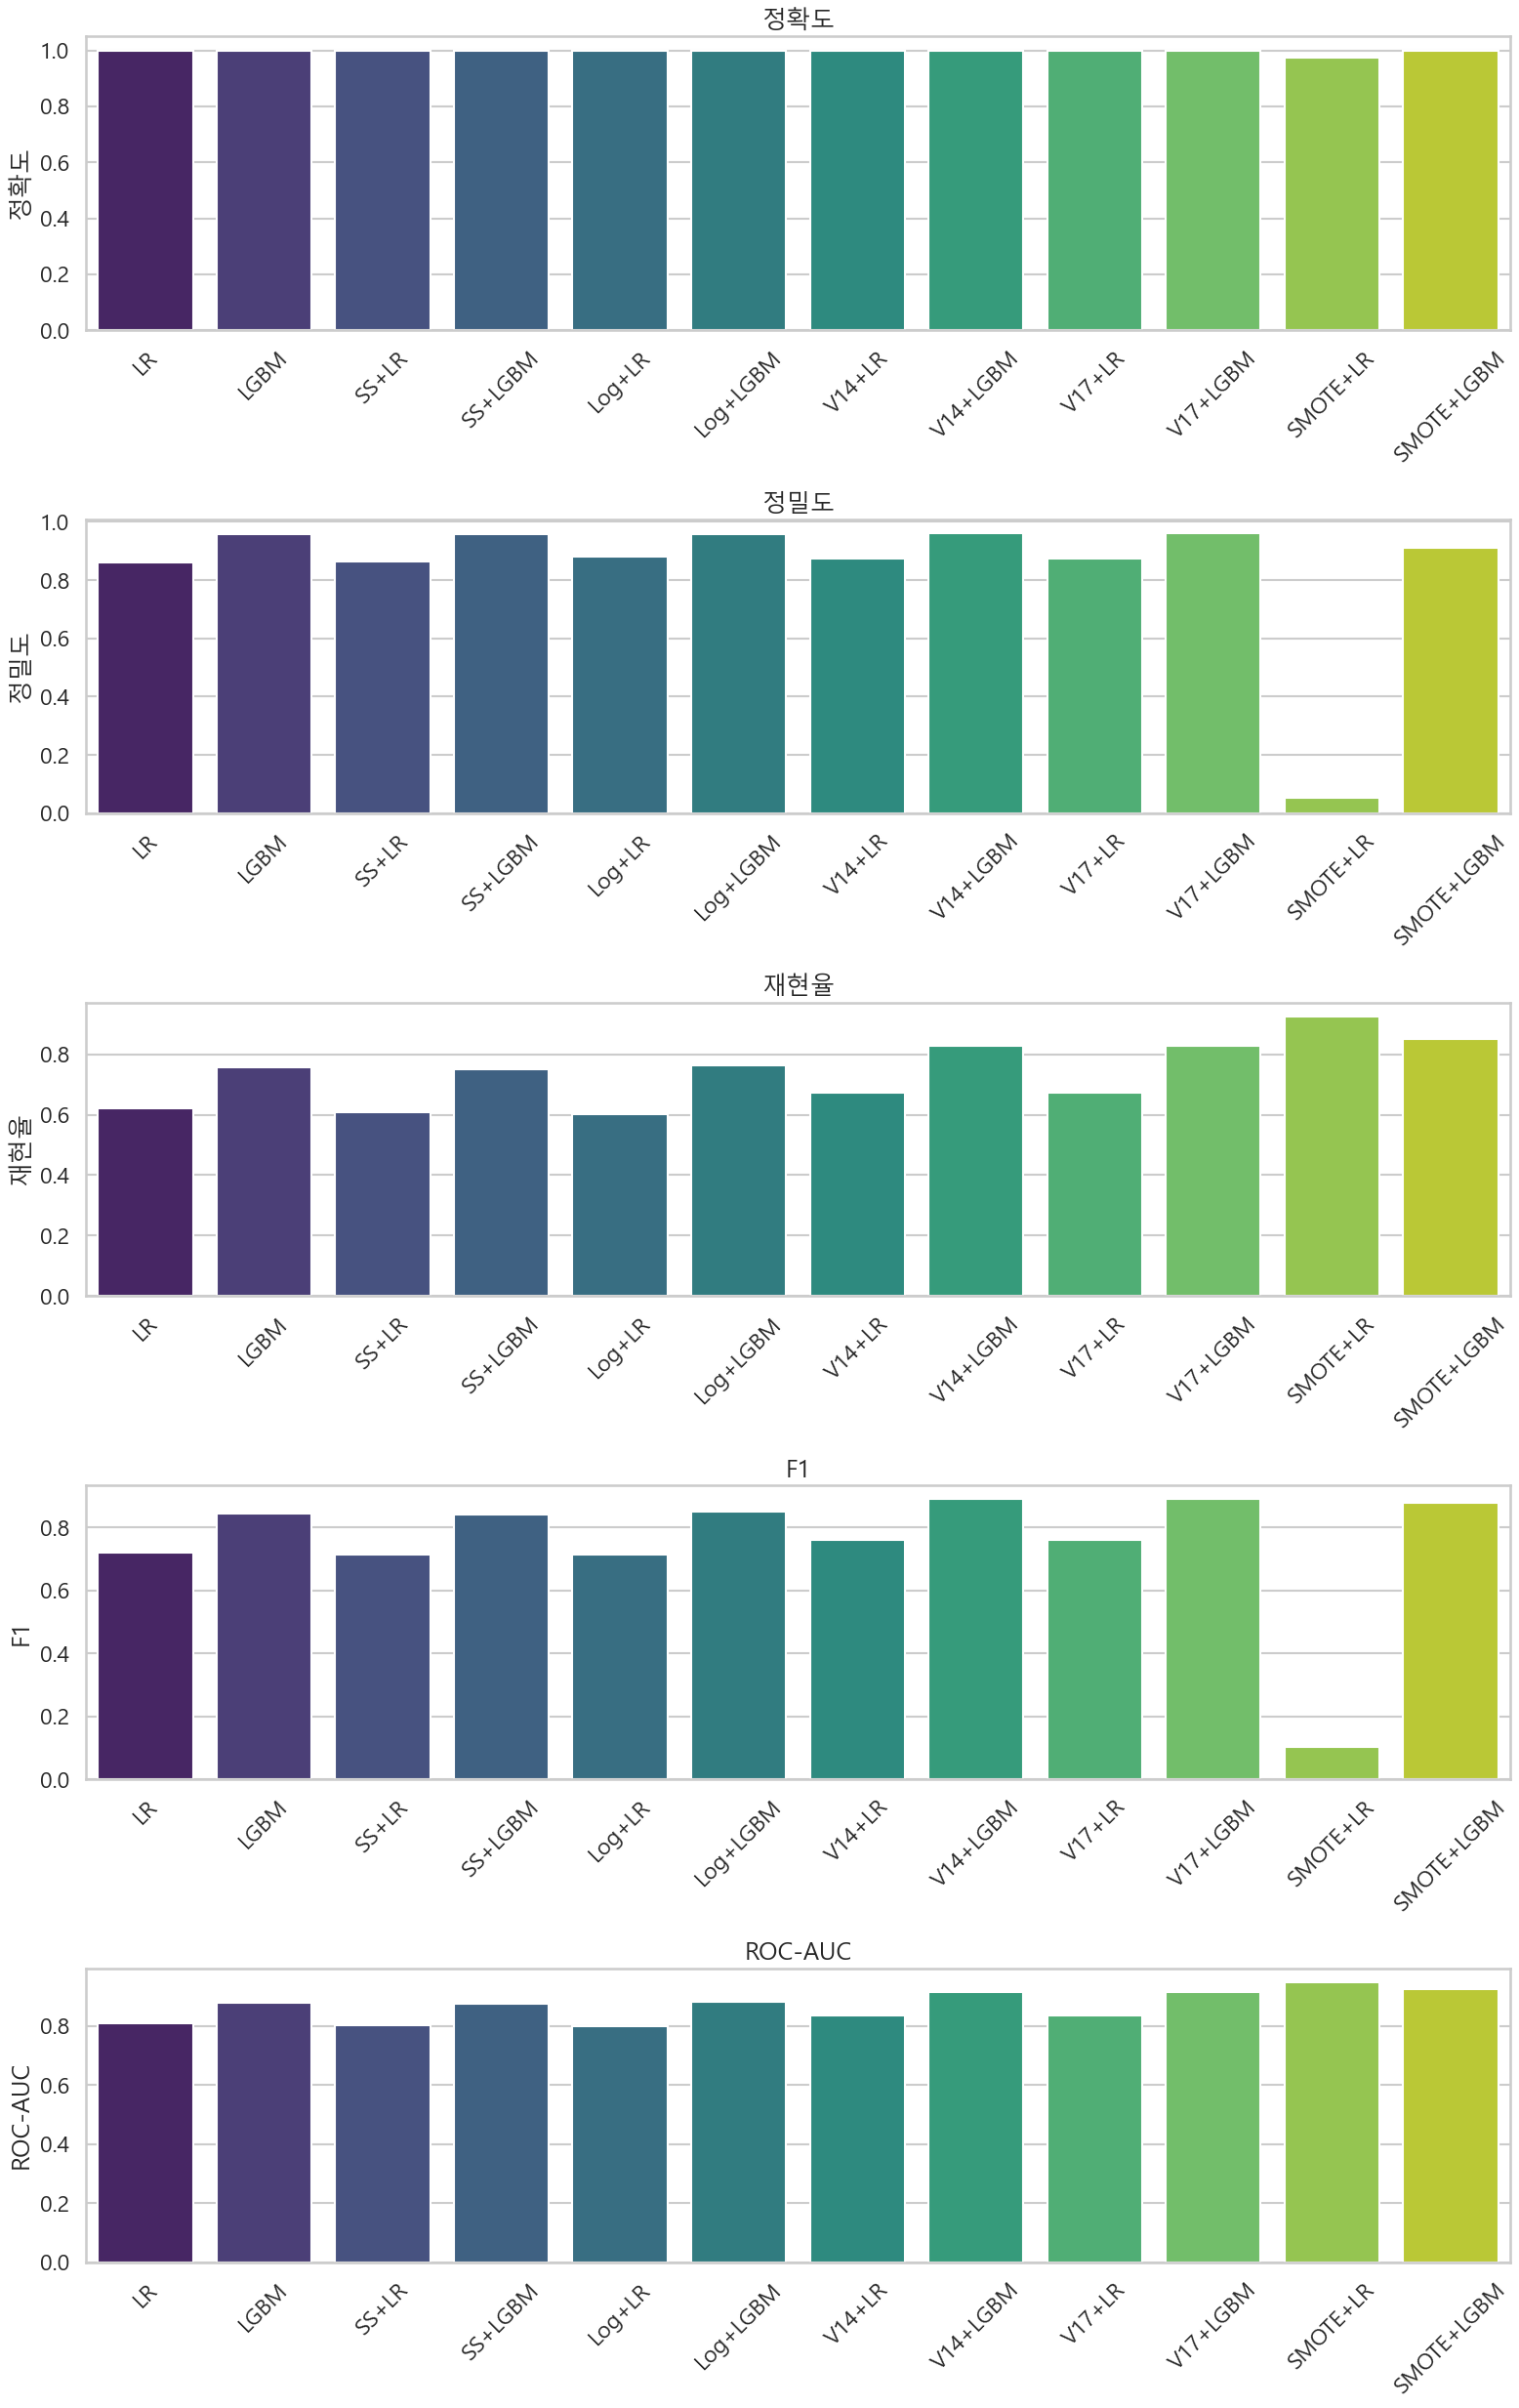

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic' 

# 데이터 준비
data = {
    '모델': [
        'LR', 'LGBM', 'SS+LR', 'SS+LGBM',
        'Log+LR', 'Log+LGBM',
        'V14+LR', 'V14+LGBM',
        'V17+LR', 'V17+LGBM',
        'SMOTE+LR', 'SMOTE+LGBM'
    ],
    '정확도': [
        0.9992, 0.9995, 0.9992, 0.9995, 0.9992, 0.9995, 
        0.9993, 0.9996, 0.9993, 0.9996, 0.9723, 0.9996
    ],
    '정밀도': [
        0.8598, 0.9573, 0.8654, 0.9569, 0.8812, 0.9576,
        0.8750, 0.9603, 0.8750, 0.9603, 0.0542, 0.9118
    ],
    '재현율': [
        0.6216, 0.7568, 0.6081, 0.7500, 0.6014, 0.7635,
        0.6712, 0.8288, 0.6712, 0.8288, 0.9247, 0.8493
    ],
    'F1': [
        0.7216, 0.8453, 0.7143, 0.8409, 0.7149, 0.8496,
        0.7597, 0.8897, 0.7597, 0.8897, 0.1023, 0.8794
    ],
    'ROC-AUC': [
        0.8107, 0.8783, 0.8040, 0.8751, 0.8006, 0.8817,
        0.8355, 0.9144, 0.8355, 0.9144, 0.9485, 0.9246
    ]
}

df = pd.DataFrame(data)

# 시각화
metrics = ['정확도', '정밀도', '재현율', 'F1', 'ROC-AUC']
plt.figure(figsize=(16, len(metrics) * 5)) # 그래프 크기 조정

for i, metric in enumerate(metrics):
    plt.subplot(len(metrics), 1, i + 1)
    sns.barplot(x='모델', y=metric, data=df, palette="viridis")
    plt.xticks(rotation=45)
    plt.title(metric)
    plt.xlabel("")

plt.tight_layout()
plt.show()


# 각 지표별 최고의 예측 성능 모델

| **지표**   | **최고 성능 모델**                   | **값**   |
|------------|-------------------------------------|----------|
| 정확도     | V14 이상치처리+LGBM, V17 이상치처리+LGBM | 0.9996   |
| 정밀도     | V14 이상치처리+LGBM, V17 이상치처리+LGBM | 0.9603   |
| 재현율     | SMOTE오버샘플링+LogisticRegression | 0.9247   |
| F1 점수    | V14 이상치처리+LGBM, V17 이상치처리+LGBM | 0.8897   |
| ROC-AUC    | SMOTE오버샘플링+LogisticRegression | 0.9485   |


- V14와 V17 이상치 처리는 Logistic Regression, LightGBM과 결합했을 때 동일한 성능을 제공하며, 모든 주요 지표에서 균형 잡힌 우수한 결과를 도출했습니다.
- SMOTE 오버샘플링은 LogisticRegression에서 재현율과 ROC-AUC를 극대화했지만, 정밀도가 크게 저하되어 실제 활용에는 한계가 있습니다.
- 데이터 전처리가 모델 성능에 중요한 영향을 미쳤으며, 특히 **Logistic Regression, LightGBM**과 결합된 이상치 처리가 최고의 결과를 제공했습니다.